### 1. Data Preprocessing ###

This step I read the scaled dataset, and remove invalid data. Then I convert them to np arrays and print the shapes of label and features.

In [1]:
# Understand the original data format and features
with open('/home/hgq/Projects/DLF/diabetes.csv', 'r') as f:
    data = f.readlines()
print(data[0])
print(data[1:10])

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome

['6,148,72,35,0,33.6,0.627,50,1\n', '1,85,66,29,0,26.6,0.351,31,0\n', '8,183,64,0,0,23.3,0.672,32,1\n', '1,89,66,23,94,28.1,0.167,21,0\n', '0,137,40,35,168,43.1,2.288,33,1\n', '5,116,74,0,0,25.6,0.201,30,0\n', '3,78,50,32,88,31,0.248,26,1\n', '10,115,0,0,0,35.3,0.134,29,0\n', '2,197,70,45,543,30.5,0.158,53,1\n']


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


# Load Data
with open('/home/hgq/Projects/DLF/diabetes_scale.txt', 'r') as f:
    data = f.readlines()

x = []
y = []

for line in data:
    parts = line.strip().split()
    label = int(parts[0])
    features = []
    for feature in parts[1:]:
        index, value = feature.split(":")
        features.append(float(value))

    # By reading the csv dataset, there are total 8 features. So here I remove those invalid data.
    if len(features) == 8:
        x.append(features)
        y.append(label)

# Convert the data into numpy arrays
x = np.array(x)
y = np.array(y)

print(f"Data shape: {x.shape}")
print(f"Labels shape: {y.shape}")


Data shape: (759, 8)
Labels shape: (759,)


### 2. Splitting the Dataset ###

This step I used 60% of data for training, 20% for validation and 20% testing.

In [3]:
# Split the dataset into training, validation, and test sets
split_train = 0.6
split_val = 0.2
split_index_train = int(len(x) * split_train)
split_index_val = int(len(x) * (split_train + split_val))

x_train, x_val, x_test = x[:split_index_train], x[split_index_train:split_index_val], x[split_index_val:]
y_train, y_val, y_test = y[:split_index_train], y[split_index_train:split_index_val], y[split_index_val:]

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

Training set size: 455
Validation set size: 152
Test set size: 152


### 3. Model Selection ###

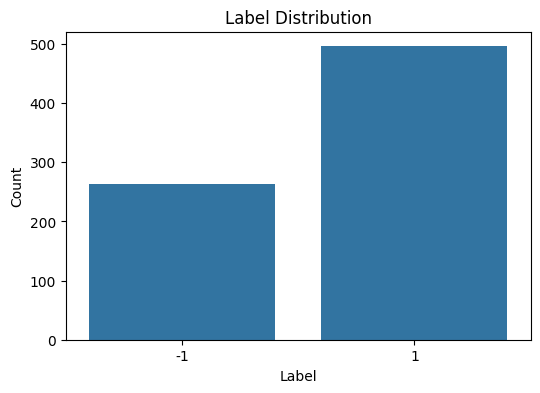

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Visualized the distribution of label
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


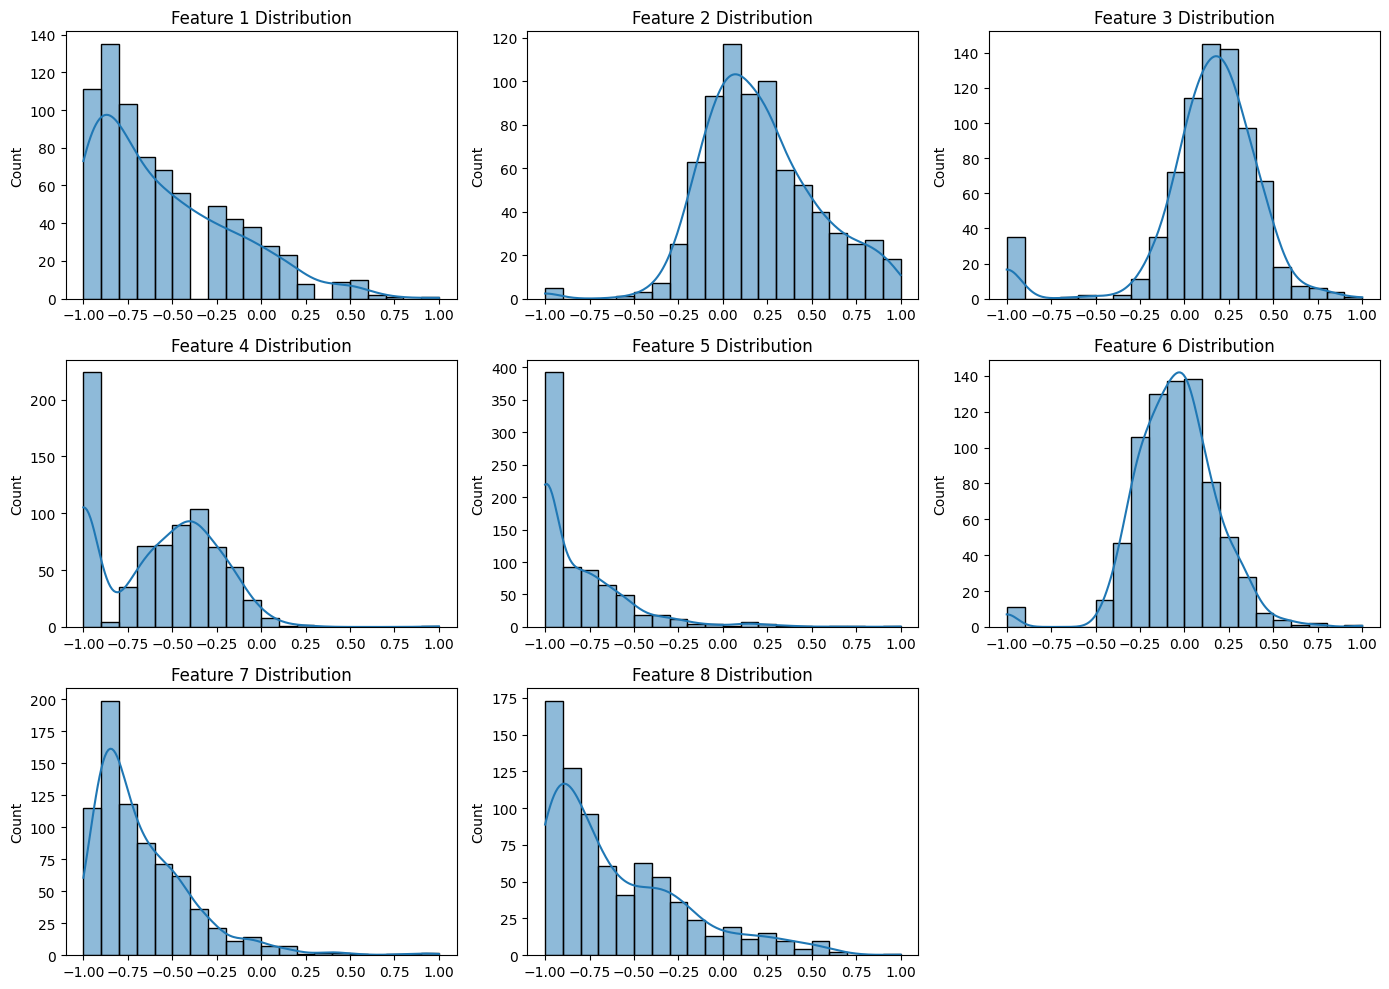

In [5]:
# # Visualized the distribution of features 
plt.figure(figsize=(14, 10))
for i in range(8):
    plt.subplot(3, 3, i+1)
    sns.histplot(x[:, i], kde=True, bins=20)
    plt.title(f'Feature {i+1} Distribution')
plt.tight_layout()
plt.show()


This visualization shows the distribution of each feature in the dataset. Features 1, 4, 5, 7, and 8 show right-skewed distributions. Furthermore, they have large numbers of values near -1 and fewer higher values. On the other hand, Features 2, 3, and 6 display near-normal distributions centered around 0.

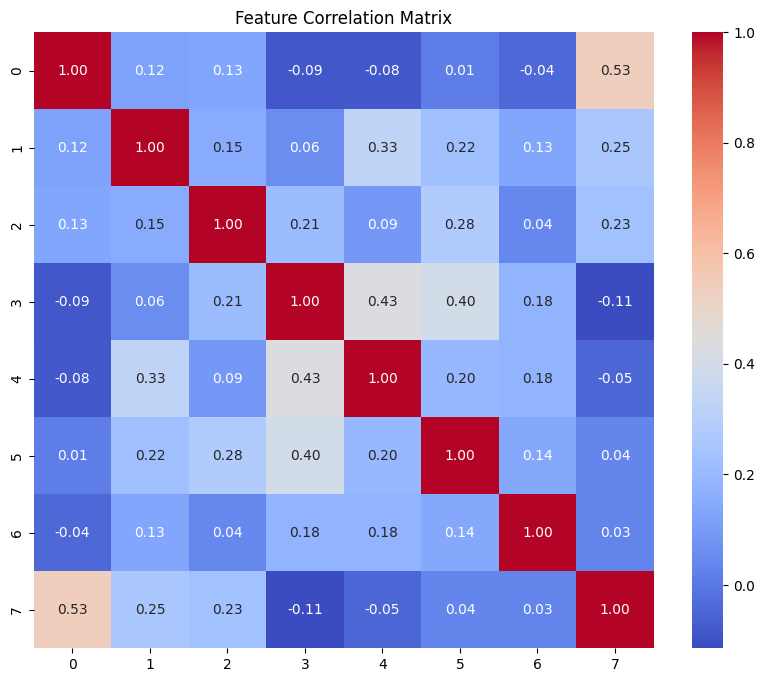

In [6]:
# Visualized correlation matrix between features
correlation_matrix = np.corrcoef(x.T)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

This chart indicates the correlation coefficients between most features are close to 0, which menas the linear relationship between these features is weak. This situation benefit for model training because the model can learn different information from multiple independent features.

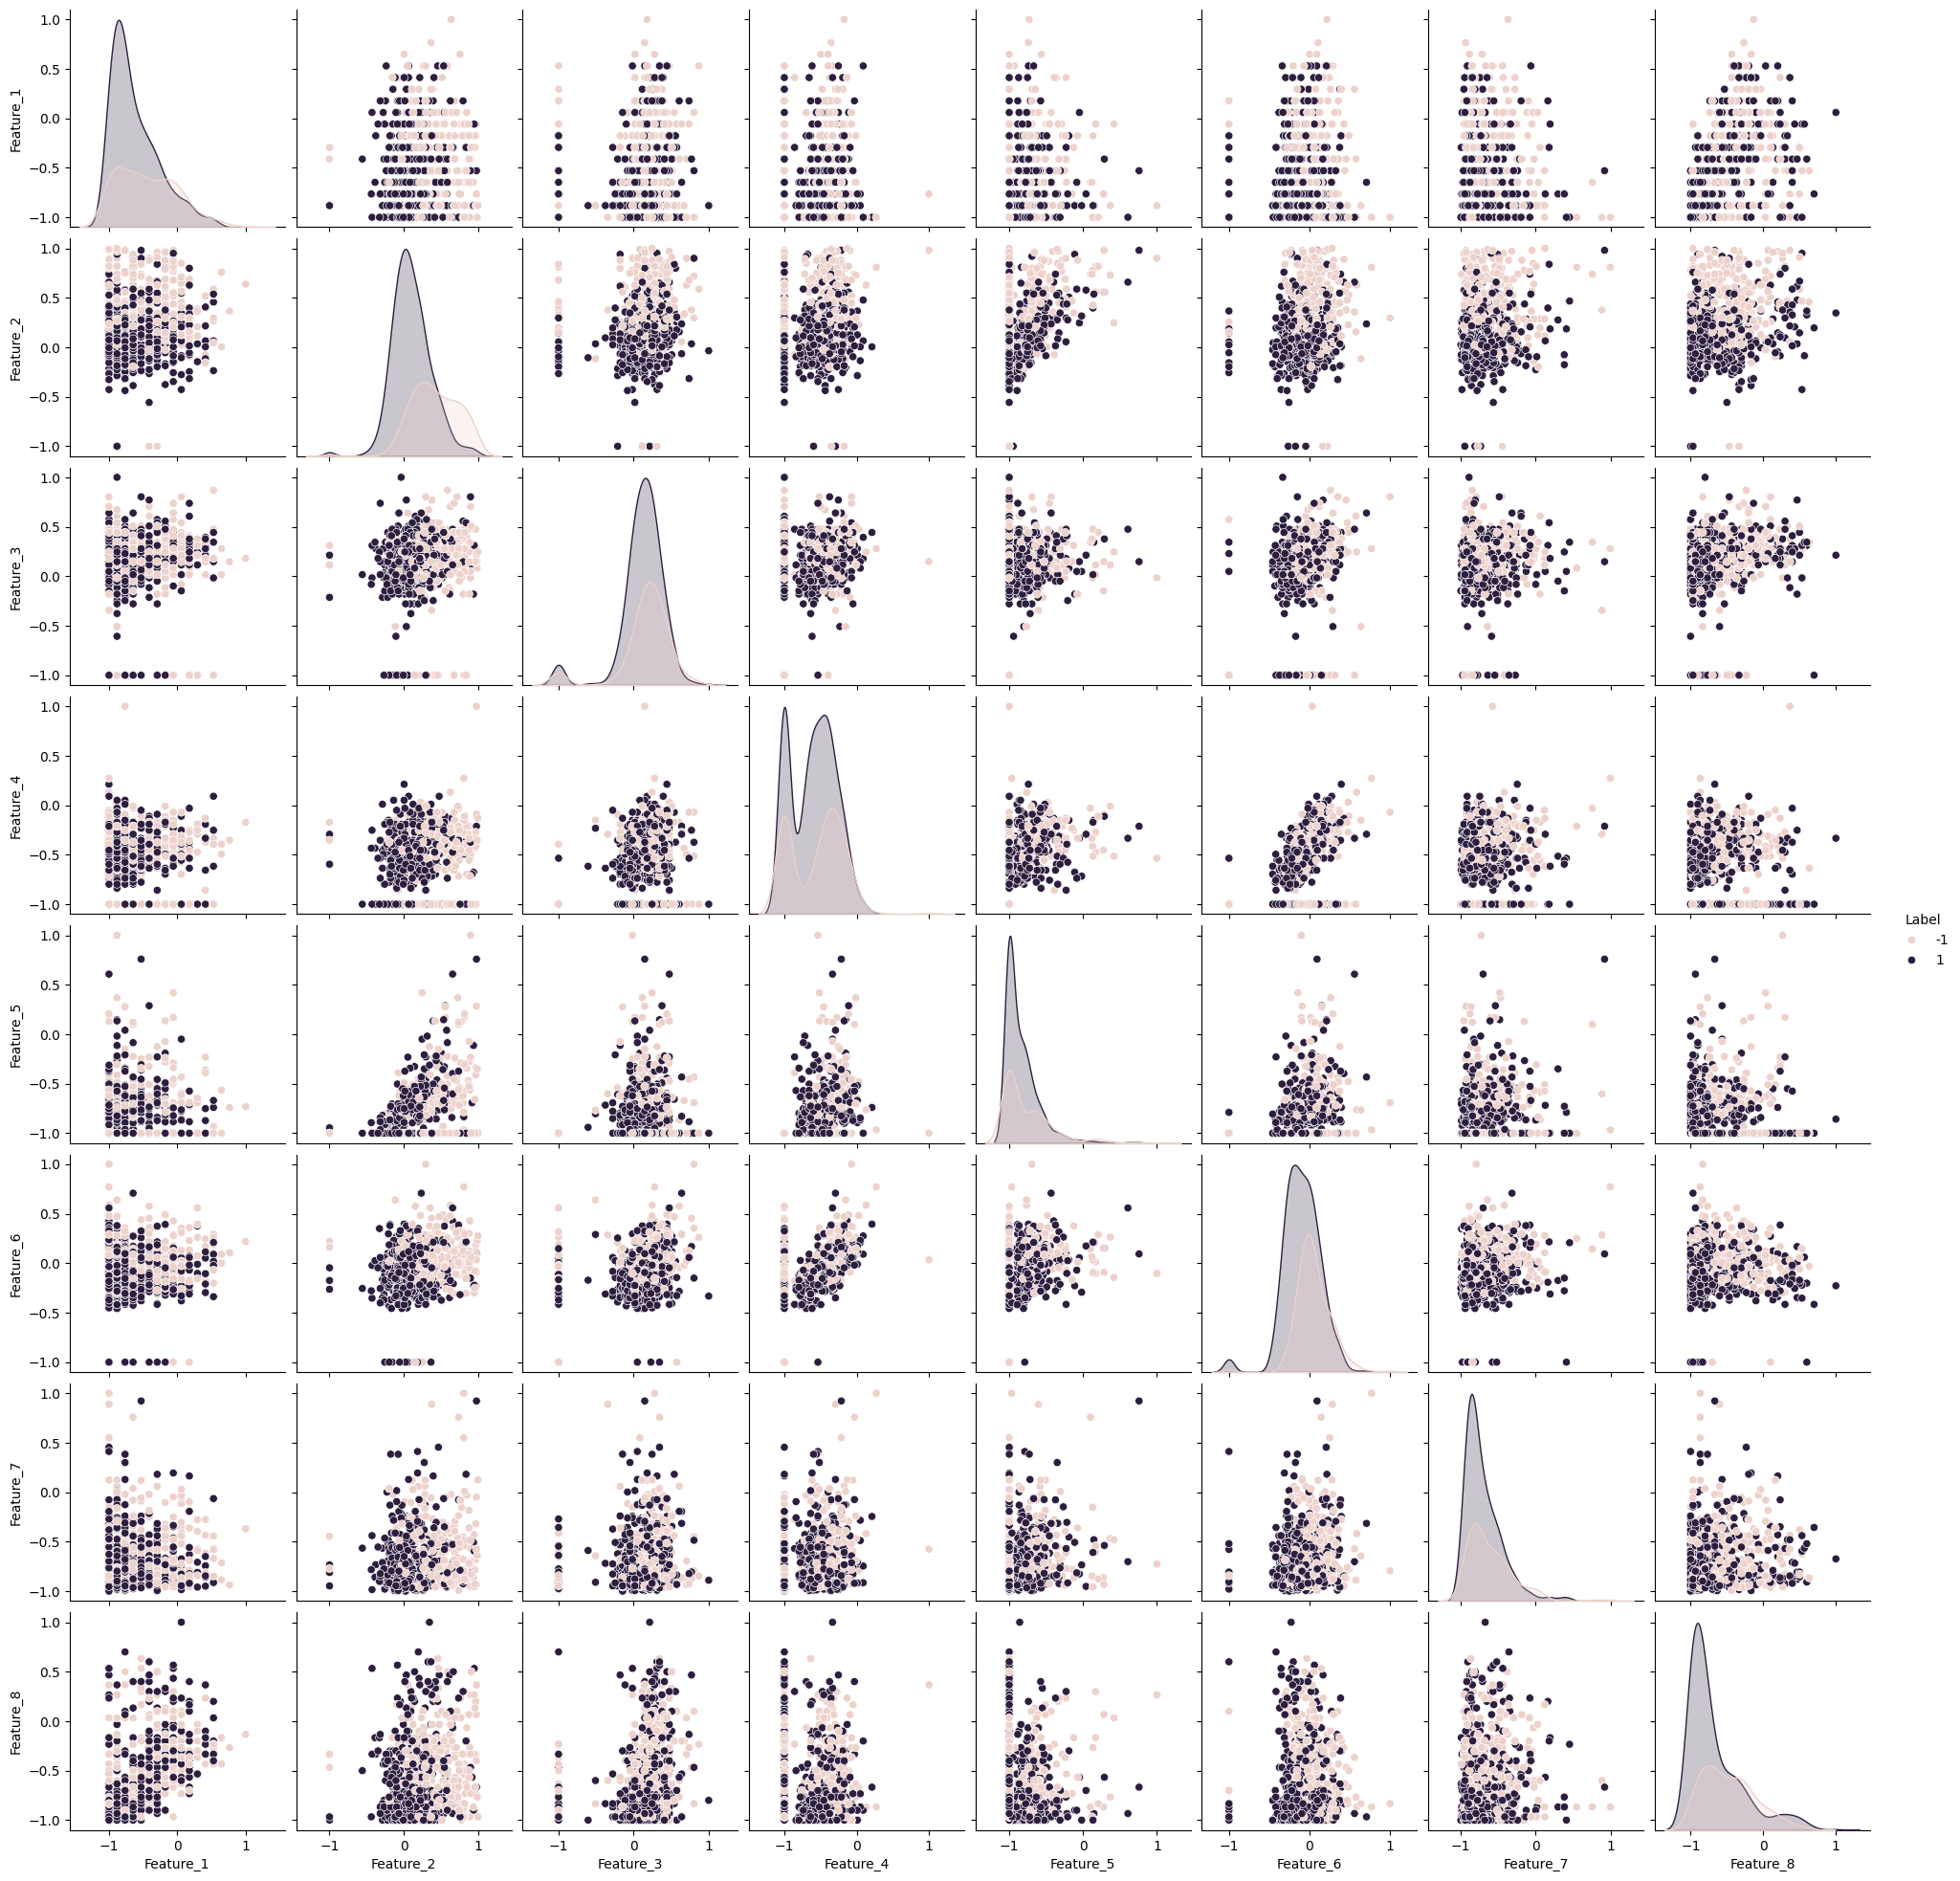

In [7]:
# Pairplot
import pandas as pd
data_df = pd.DataFrame(x, columns=[f'Feature_{i+1}' for i in range(8)])
data_df['Label'] = y

sns.pairplot(data_df, hue='Label', diag_kind='kde')
plt.show()

There is no significant linear relationship between data features, and the features are relatively independent. This chart also indicates these features are suitable for model training.
However, there is no clear separation of categories in the feature space, and more complex models may be needed to better distinguish these categories, such as MLP, random forest and other models that are suitable for non-linear problem.
To further confirm whether the dataset is nonlinear, I used PCA dimensionality reduction to observe the label distribution here

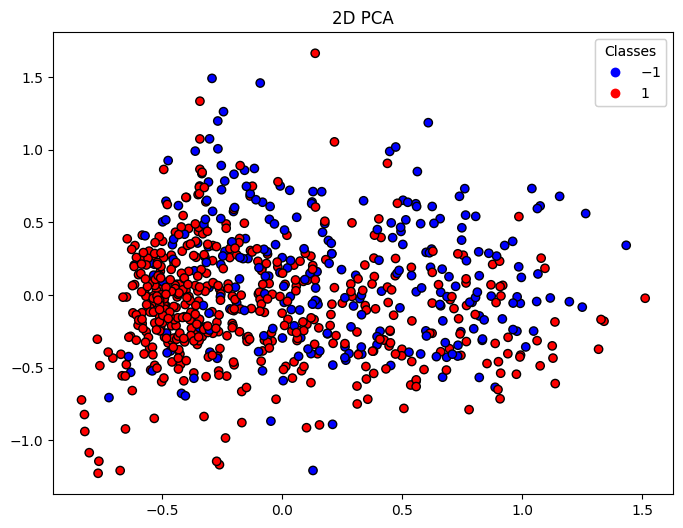

In [8]:
# Applied PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# Visualized
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='bwr', edgecolors='k')
plt.title('2D PCA')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend)

plt.show()

In [9]:
import plotly.graph_objects as go


pca = PCA(n_components=3)
x_pca = pca.fit_transform(x)

fig = go.Figure(data=[go.Scatter3d(
    x=x_pca[:, 0],
    y=x_pca[:, 1],
    z=x_pca[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=y,
        colorscale='Viridis', 
        opacity=0.8,
        line=dict(width=1)
    )
)])

fig.update_layout(scene = dict(
                    xaxis_title='1',
                    yaxis_title='2',
                    zaxis_title='3'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


Based on these two chart, the data appears to present a non-linearly separable problem. However, since I applied PCA at this stage, some information may lost. Therefore, I plan to use MLP and random forest to see if they can achieve better performance, and use perceptron, linearSVM for comparison.

### 4. Training and Evaluation ###

#### 4.1 Perceptron #####

In [10]:
# Model training and evaluation function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def training(x_train, y_train, x_val, y_val, learning_rate, num_epochs=50, patience=6):
    weight = np.ones(x_train.shape[1])  # Initialize weights
    bias = 0

    best_val_f1 = 0
    best_weights = None
    best_bias = None
    no_improve_epochs = 0 

    val_f1_scores = []

    for epoch in range(num_epochs):
        # Train on training data
        for i in range(len(x_train)):
            x = x_train[i]
            y = y_train[i]
            y_predict = sign(np.dot(weight, x) + bias)
            if y * y_predict <= 0:  # Update weights and bias if wrong prediction
                weight += learning_rate * y * x
                bias += learning_rate * y

        # Evaluate on validation set
        accuracy, precision, recall, f1 = evaluate(x_val, y_val, weight, bias)
        val_f1_scores.append(f1)
        print(f"Epoch {epoch+1}/{num_epochs}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

        # Early stopping
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_weights = weight.copy()
            best_bias = bias
            no_improve_epochs = 0 
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"Best Validation F1 Score: {best_val_f1:.4f}")
    return best_weights, best_bias, val_f1_scores

# Evaluation
def evaluate(x, y, weight, bias):
    y_pred = []
    for i in range(len(x)):
        y_predict = sign(np.dot(weight, x[i]) + bias)
        y_pred.append(y_predict)
    
    precision = precision_score(y, y_pred, average='binary')
    recall = recall_score(y, y_pred, average='binary')
    f1 = f1_score(y, y_pred, average='binary')
    accuracy = accuracy_score(y, y_pred)

    return precision, recall, f1, accuracy

# Sign function for prediction
def sign(v):
    return 1 if v > 0 else -1


In [11]:
# Grid Search
def grid_search_learning_rate(x_train, y_train, x_val, y_val, learning_rates, num_epochs=50, patience=6):
    best_f1_score = 0
    best_lr = None
    all_results = []

    for lr in learning_rates:
        print(f"Training with learning_rate={lr:.4f}, num_epochs={num_epochs}")
        weight, bias, val_f1_scores = training(x_train, y_train, x_val, y_val, learning_rate=lr, num_epochs=num_epochs, patience=patience)
        final_val_f1 = val_f1_scores[-1]
        all_results.append((lr, final_val_f1, val_f1_scores))

        if final_val_f1 > best_f1_score:
            best_f1_score = final_val_f1
            best_lr = lr

    return best_lr, best_f1_score, all_results

# Define the learning rate search space
learning_rates = np.arange(0.01, 0.56, 0.05)

best_lr, best_f1_score, all_results = grid_search_learning_rate(x_train, y_train, x_val, y_val, learning_rates)

print("-"*10)
print(f"Best Learning rate = {best_lr}")


Training with learning_rate=0.0100, num_epochs=50
Epoch 1/50, Precision: 0.6549, Recall: 0.6697, F1 Score: 0.5197, Accuracy: 0.6852
Epoch 2/50, Precision: 0.8142, Recall: 0.7699, F1 Score: 0.6382, Accuracy: 0.7302
Epoch 3/50, Precision: 0.8938, Recall: 0.8523, F1 Score: 0.7697, Accuracy: 0.8145
Epoch 4/50, Precision: 0.9027, Recall: 0.8793, F1 Score: 0.8158, Accuracy: 0.8571
Epoch 5/50, Precision: 0.9558, Recall: 0.8816, F1 Score: 0.8092, Accuracy: 0.8182
Epoch 6/50, Precision: 0.9646, Recall: 0.8862, F1 Score: 0.8158, Accuracy: 0.8195
Epoch 7/50, Precision: 0.9646, Recall: 0.8755, F1 Score: 0.7961, Accuracy: 0.8015
Epoch 8/50, Precision: 0.9912, Recall: 0.8517, F1 Score: 0.7434, Accuracy: 0.7467
Epoch 9/50, Precision: 0.9646, Recall: 0.8826, F1 Score: 0.8092, Accuracy: 0.8134
Epoch 10/50, Precision: 0.9646, Recall: 0.8755, F1 Score: 0.7961, Accuracy: 0.8015
Early stopping at epoch 10
Best Validation F1 Score: 0.8158
Training with learning_rate=0.0600, num_epochs=50
Epoch 1/50, Precisi

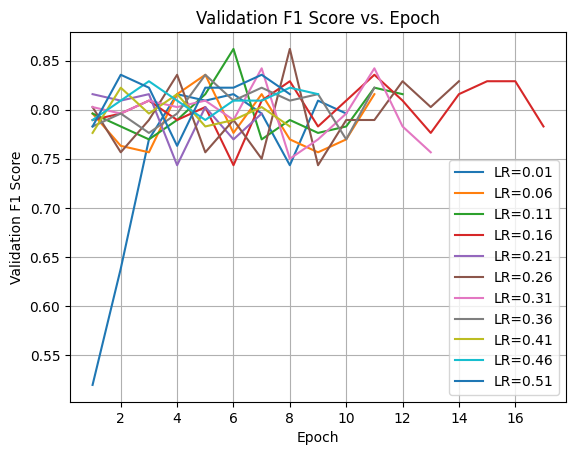

In [12]:
# Plot the F1 scores vs epoch for each learning rate
def plot_f1_scores(all_results):
    for lr, final_val_f1, val_f1_scores in all_results:
        plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label=f'LR={lr:.2f}')

    plt.xlabel('Epoch')
    plt.ylabel('Validation F1 Score')
    plt.title('Validation F1 Score vs. Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the F1 scores
plot_f1_scores(all_results)

In [13]:
# Train the model using the best learning rate and save the weight and bias
weight, bias, _ = training(x_train, y_train, x_val, y_val, learning_rate=best_lr, num_epochs=50)

Epoch 1/50, Precision: 0.9469, Recall: 0.8770, F1 Score: 0.8026, Accuracy: 0.8168
Epoch 2/50, Precision: 0.9912, Recall: 0.8582, F1 Score: 0.7566, Accuracy: 0.7568
Epoch 3/50, Precision: 0.9558, Recall: 0.8710, F1 Score: 0.7895, Accuracy: 0.8000
Epoch 4/50, Precision: 0.9469, Recall: 0.8954, F1 Score: 0.8355, Accuracy: 0.8492
Epoch 5/50, Precision: 1.0000, Recall: 0.8593, F1 Score: 0.7566, Accuracy: 0.7533
Epoch 6/50, Precision: 0.9646, Recall: 0.8720, F1 Score: 0.7895, Accuracy: 0.7956
Epoch 7/50, Precision: 0.9823, Recall: 0.8538, F1 Score: 0.7500, Accuracy: 0.7551
Epoch 8/50, Precision: 0.9469, Recall: 0.9106, F1 Score: 0.8618, Accuracy: 0.8770
Epoch 9/50, Precision: 0.9912, Recall: 0.8517, F1 Score: 0.7434, Accuracy: 0.7467
Epoch 10/50, Precision: 0.9646, Recall: 0.8720, F1 Score: 0.7895, Accuracy: 0.7956
Epoch 11/50, Precision: 0.9646, Recall: 0.8720, F1 Score: 0.7895, Accuracy: 0.7956
Epoch 12/50, Precision: 0.9558, Recall: 0.8926, F1 Score: 0.8289, Accuracy: 0.8372
Epoch 13/50, 

In [14]:
# Test the model on the test set
def test(x_test, y_test, weight, bias):
    p_accuracy, p_precision, p_recall, p_f1 = evaluate(x_test, y_test, weight, bias)
    print(f"Test Precision: {p_precision:.4f}, Test Recall: {p_recall:.4f}, Test F1 Score: {p_f1:.4f}")

test(x_test, y_test, weight, bias)


Test Precision: 0.8980, Test Recall: 0.8341, Test F1 Score: 0.7697


### 4.2 LinearSVM ###

In [15]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

LR_f1 = f1_score(y_test, y_pred)
LR_recall = recall_score(y_test, y_pred)
LR_precision = precision_score(y_test, y_pred)

print(f"F1 Score: {LR_f1:.4f}")
print(f"Recall: {LR_recall:.4f}")
print(f"Precision: {LR_precision:.4f}")

F1 Score: 0.8436
Recall: 0.9082
Precision: 0.7876


#### 4.3 MLP ####

In [16]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=1000, random_state=42, learning_rate_init=0.08)
mlp.fit(x_train, y_train)

MLP_y_pred = mlp.predict(x_test)

MLP_f1 = f1_score(y_test, MLP_y_pred)
MLP_recall = recall_score(y_test, MLP_y_pred)
MLP_precision = precision_score(y_test, MLP_y_pred)

print(f"F1 Score: {MLP_f1:.4f}")
print(f"Recall: {MLP_recall:.4f}")
print(f"Precision: {MLP_precision:.4f}")

F1 Score: 0.8500
Recall: 0.8673
Precision: 0.8333


#### 4.4 Random Forest ####

In [17]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(x_train, y_train)
rf_y_pred = rf.predict(x_test)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
print(f"F1 Score: {rf_f1:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"Precision: {rf_precision:.4f}")


F1 Score: 0.8462
Recall: 0.9082
Precision: 0.7876
